In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from nltk.tokenize import TweetTokenizer
import time
from torch_scatter import scatter_max, scatter_mean, scatter_std
from sklearn.model_selection import KFold
import torchmetrics
import lightning as L
from torch_geometric.data import Batch, Data
from tqdm import tqdm
import spacy
import string
import os
import re
import math
from torch import nn
from torch.utils.flop_counter import FlopCounterMode
from transformers import AutoModel, DebertaV2Tokenizer, AutoTokenizer
import matplotlib.pyplot as plt

In [2]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
model = AutoModel.from_pretrained("microsoft/deberta-v3-large")

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [3]:
id_vocab = {v:k for k,v in tokenizer.vocab.items()}
all_vocab_indices = list(id_vocab.keys())

In [4]:

# all_vocab_str = []
# vector_keys = list(nlp.vocab.vectors.keys())
# for i in range(len(vector_keys)):
#     try:
#         t = nlp.vocab.strings[vector_keys[i]]
#         all_vocab_str.append(t)
#     except:
#         continue

In [5]:
import string
# Create a set of all English characters, numbers, and punctuation
allowed_chars = string.ascii_letters + string.digits + string.punctuation
all_chars = set(allowed_chars)

In [6]:
with open(r'Data\ReducedEmbeddings\deberta_larg_reduced_embeddings_64.npy', 'rb') as f:
    embeddings = np.load(f)
embeddings = torch.from_numpy(embeddings)
all_vocab_str = []
for i in range(len(id_vocab)):
    all_vocab_str.append(id_vocab[i])
    
# embeddings = (embeddings - torch.min(embeddings)) / (torch.max(embeddings)-torch.min(embeddings))
token_vocab_dict = dict(zip(all_vocab_str, embeddings))
# del all_vocab_str
# del all_vocab_doc

In [7]:
with open(r'Data\ReducedEmbeddings\polarity_debertav3_tokens_gpt_mini_emb.npy', 'rb') as f:
    polarities_subjectivities= np.load(f)
polarities_subjectivities = torch.from_numpy(polarities_subjectivities)
polarity_vocab_dict = dict(zip(all_vocab_str, polarities_subjectivities))
polarity_vocab_dict['<n>'] = torch.tensor([0.0, 0.0])
len(token_vocab_dict)

128001

In [8]:
polarities_subjectivities.shape

torch.Size([128001, 2])

In [9]:
for i in range(len(all_vocab_str)):
    if 'nice' in all_vocab_str[i]:
        print(i, polarities_subjectivities[i])
        break

1085 tensor([0.7000, 0.6000], dtype=torch.float64)


In [10]:
import string
# Create a set of all English characters, numbers, and punctuation
allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' \t'
all_chars = set(allowed_chars)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
folder_path = r'C:\Users\fardin\Projects\CGNet\Data\TextClassification\IMDB'
# t_tokenizer = TweetTokenizer()
device

device(type='cuda')

In [12]:
keep_ratio = 1.0
test_df = pd.read_csv(r'data\TextClassification\IMDB\test.csv')
test_df['Topic'] = test_df['label']
# test_df['Content'] = [test_df.text[i].values[0] + " \n " + test_df.text[i].values[1] for i in range(len(test_df))]
test_df['Content'] = test_df['text']
# test_df['Content'] = test_df['Content']
test_df.drop(['label', 'text'], axis=1, inplace=True)
test_df.dropna(inplace=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.iloc[:int(keep_ratio*test_df.shape[0])]
train_df = pd.read_csv(r'data\TextClassification\IMDB\train.csv')
train_df['Topic'] = train_df['label']
# train_df['Content'] = [train_df.text[i].values[0] + " \n " + train_df.text[i].values[1] for i in range(len(train_df))]
train_df['Content'] = train_df['text']
train_df.drop(['label', 'text'], axis=1, inplace=True)
train_df.dropna(inplace=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df = train_df.iloc[:int(keep_ratio*train_df.shape[0])]
sst_classes = ["Negative", "Positive"]
df = pd.DataFrame(np.concatenate([train_df.values, test_df.values]), columns=train_df.columns)
df.shape

(50000, 2)

In [13]:
%%time
doc_lengths = np.array([len(df.Content[i]) for i in df.index])
print(np.max(doc_lengths))

13704
CPU times: total: 1.09 s
Wall time: 1.12 s


In [14]:
# class_list = df.Topic.unique()
class_id = {c:i for i, c in enumerate(sst_classes)}
id_class = {i:c for i, c in enumerate(sst_classes)}

In [15]:
# vocab_dict = {c:i for i, c in enumerate(allowed_chars)}
# if '\x01' not in vocab_dict:
#     vocab_dict['\x01'] = len(vocab_dict)
# char_Set = set(vocab_dict.keys())
# len(char_Set)

13704


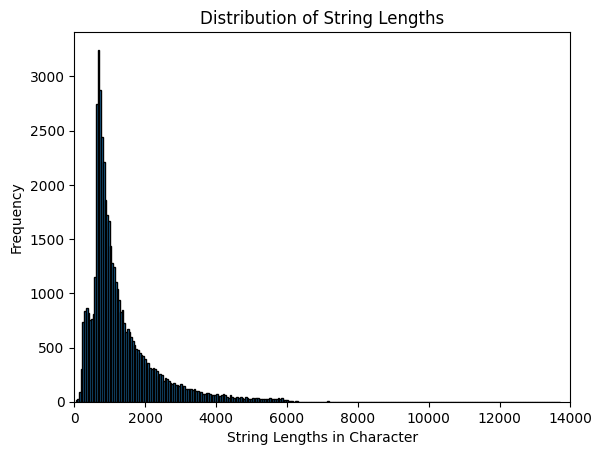

In [16]:
# Create a histogram
plt.hist(doc_lengths, bins='auto', edgecolor='black')
plt.xlim([0,14000])
# Add labels and title
plt.xlabel('String Lengths in Character')
plt.ylabel('Frequency')
plt.title('Distribution of String Lengths')
print(doc_lengths.max())
# Show the chart
plt.show()

In [17]:
%%time
doc_token_lengths = np.array([len(tokenizer.tokenize(df.Content[i])) for i in df.index])

CPU times: total: 1min 31s
Wall time: 1min 34s


3088


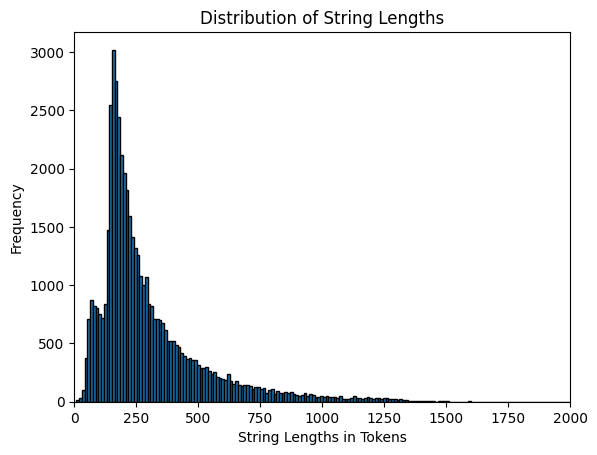

In [18]:
# Create a histogram
plt.hist(doc_token_lengths, bins='auto', edgecolor='black')
plt.xlim([0,2000])
# Add labels and title
plt.xlabel('String Lengths in Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of String Lengths')
print(doc_token_lengths.max())
# Show the chart
plt.show()

In [19]:
'▁Too'.strip('▁').lower()

'too'

In [20]:
# %%time
vocabs_lists = list(token_vocab_dict.keys())
term_frequencies = {t:1 for t in vocabs_lists}
temp_term_frequencies = {}

char_set = set()
for doc in train_df.Content.values:
    tokens_list = tokenizer.tokenize(doc)
    char_set.update(set(' '.join(tokens_list)))
    char_set.update(set(doc))
    new_tokens = {t.strip('▁').lower() for t in tokens_list}
    for t in new_tokens:
        if t not in temp_term_frequencies:
            temp_term_frequencies[t] = 0
        temp_term_frequencies[t] += 1
        
# stripped_key_pairs = {}
# stripped_key_frequencies = {}
# for k in vocabs_lists:
#     stripped_k = k.strip('▁').lower()
#     stripped_key_pairs[k] = stripped_k
    # if stripped_k not in stripped_key_frequencies:
    #     stripped_key_frequencies[stripped_k] = 0
    # stripped_key_frequencies[stripped_k] += v
    
for k, v in term_frequencies.items():
    stripped_token = k.strip('▁').lower()
    term_frequencies[k] = temp_term_frequencies[stripped_token] if stripped_token in temp_term_frequencies else 1
    # token_frequencies[k] = temp_token_frequencies[stripped_key_pairs[k]]
    
# del stripped_key_pairs
# del stripped_key_frequencies
del temp_term_frequencies
    
for doc in test_df.Content.values:
    char_set.update(set(' '.join(tokenizer.tokenize(doc))))
    char_set.update(set(doc))
len(char_set)

allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' '
all_chars = set(''.join(char_set).join(allowed_chars))
vocab_dict = {c:i for i, c in enumerate(all_chars)}
if '\x01' not in vocab_dict:
    vocab_dict['\x01'] = len(vocab_dict)
char_Set = set(vocab_dict.keys())
num_embedding = len(vocab_dict)
vocab_dict_rev = dict(zip(list(vocab_dict.values()), list(vocab_dict.keys())))

In [21]:
# def subsampling_equation_sigmoid(x: torch.Tensor):
#     x = 0.9*F.sigmoid(0.06*(70-x))
#     return x

In [22]:
set(torch.tensor([1,4,3,5,4]))

{tensor(1), tensor(3), tensor(4), tensor(4), tensor(5)}

In [23]:
threshold = 0.00001
total_token_count = np.array(list(term_frequencies.values())).sum()
one_tensor = torch.tensor(1)
def subsampling_equation_linear(x: torch.Tensor):
    f_x = x/total_token_count
    x = torch.min(one_tensor, torch.sqrt_(threshold/f_x))
    return x

def subsampling_equation_sigmoid(x: torch.Tensor):
    f_x = x/total_token_count
    x = 1-0.95*F.sigmoid(0.05*((f_x/threshold)-90))
    return x

In [24]:
total_token_count
676/total_token_count

4.0365597667011765e-05

In [25]:
print(f'subsample: {subsampling_equation_sigmoid(torch.from_numpy(np.array([term_frequencies["were"]])))}')

subsample: tensor([0.9262])


In [26]:
term_frequencies["▁is"]
term_frequencies["king"]

676

In [27]:
print(f'subsample: {subsampling_equation_sigmoid(torch.from_numpy(np.array([term_frequencies["king"]])))}')

subsample: tensor([0.9873])


In [28]:
class CharacterandTokenLevelCustomDataset(Dataset):
    
    def __init__(self, X, y, num_classes, char_dict, token_dict, sentiment_dict, tokenizer, token_frequencies, sampling_equation, shuffle=True, batch_size=128) -> None:
        super().__init__()
        # y = y[indices].values
        # y = torch.from_numpy(np.array([class_id[c] for c in y], dtype=np.longlong))
        
        # print(f'self.num_sections1: {len(y) // batch_size}')
        # self.sampling_equation = sampling_equation
        if len(y) % batch_size != 0:
            self.shortage = ((len(y) // batch_size)+1)*batch_size - len(y)
            empty_labels = [i%2 for i in range(self.shortage)]
            empty_strings = [id_class[l] for l in empty_labels]
            
            # print(f'y1 - {y.shape}: {y}')
            y = np.concatenate([y, empty_labels])
            # print(f'y2 - {y.shape}: {y}')
            # print(f'X1 - {X.shape}: {X}')
            X = np.concatenate([X, empty_strings])
        #     print(f'X2 - {X.shape}: {X}')
        
        # print(f'self.num_sections2: {len(y) // batch_size}')
        
        y = torch.from_numpy(y)
        self.shuffle = shuffle
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        self.X = X
        self.char_dict = char_dict
        self.char_Set = set(char_dict.keys())
        self.vocab_size = len(self.char_dict)
        self.tokenizer = tokenizer
        self.token_dict = token_dict
        self.sentiment_dict = sentiment_dict
        self.token_frequencies = token_frequencies
        self.max_token_count = 0
        
        
        self.all_data = []
        self.token_lengths = []
        self.token_embeddign_ids = []
        
        self.sum_a = 0
        
        for doc in tqdm(self.X):
            g_data = self.content_to_graph(doc, sampling_equation)
            self.all_data.append(g_data)
        
        
        self.num_sections = len(y) // batch_size
        self.x_lengths = np.array([self.all_data[i].character_length for i in range(len(self.all_data))])
        self.x_len_args = np.argsort(self.x_lengths)[::-1]
        
        self.section_ranges = np.linspace(0, len(self.x_len_args), self.num_sections+1)
        self.section_ranges = [(int(self.section_ranges[i-1]), int(self.section_ranges[i])) for i in range(1, len(self.section_ranges))]

        self.position_j = 0
        self.section_i = 0
        self.epoch = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
        self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        
    def __getitem__(self, index):
        index = self.get_section_index()
        return self.all_data[index], self.y[index]
        
    def __len__(self):
        return len(self.y)
    
    def get_section_index(self):
        # if self.shuffle:
            
        #     t_range = self.section_ranges[self.section_i]
        #     target_index = np.random.randint(t_range[0], t_range[1])
        # else:
        #     t_range = self.section_ranges[self.section_i]
        #     target_index = t_range[0] + self.each_section_i[self.section_i]
        #     self.each_section_i[self.section_i] = (self.each_section_i[self.section_i] + 1) % (t_range[1] - t_range[0])
        # print()
        # print(f'self.section_i: {self.section_i},   self.position_j: {self.position_j}')
        target_index = self.sections[self.section_i, self.position_j]
        
        self.position_j = (self.position_j + 1) % self.section_size
        if self.position_j == 0:
            self.section_i = (self.section_i + 1) % self.num_sections
            if self.shuffle and self.section_i == 0:
                self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
                # random_positions = np.random.choice(np.arange(0, self.section_size), size=self.section_size, replace=False)
        # return self.x_len_args[target_index]
        return target_index

    def reset_params(self):
        self.section_i = 0
        self.position_j = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
    def split_into_k_groups(self, len_sorted_args, lengths:np.array, k):
        if self.shuffle and self.epoch > 0:
            randomize_sections = np.concatenate([np.random.choice(np.arange(r[0], r[1]), size=r[1]-r[0], replace=False) for r in self.section_ranges])
            len_sorted_args = len_sorted_args[randomize_sections]
        
        nums = lengths[len_sorted_args]
        groups_size = len(len_sorted_args) // k
        
        
        groups = [[] for _ in range(k)]
        group_sums = np.zeros(k, dtype=int)
        group_sizes = np.zeros(k, dtype=int)
        
        # print(f'groups_size: {groups_size}')
        # print(f'len(len_sorted_args): {len(len_sorted_args)}')
        # print(f'k: {k}')
        for i, num in enumerate(nums):
            candidate_indices = np.where(group_sizes<groups_size)[0]
            # print(f'candidate_indices: {candidate_indices}')
            min_group_idx = candidate_indices[np.argmin(group_sums[candidate_indices])]
            groups[min_group_idx].append(len_sorted_args[i])
            group_sums[min_group_idx] += num
            group_sizes[min_group_idx] += 1
        self.epoch += 1
        
        groups = np.array(groups)
        group_sums_argsort = np.argsort(group_sums)[::-1]
        groups = groups[group_sums_argsort]
        
        # check_x = self.X[groups]
        # check_x_lens = [np.sum(np.array([len(sx) for sx in rx])) for rx in check_x]
        # print(f'check_x: {check_x}')
        
        
        return np.array(groups), groups_size
        
    def content_to_graph(self, doc, sampling_equation):
        # tokens = self.tokenizer(''.join(c for c in doc if c in self.char_Set))
        # tokens = [t.text for t in tokens]
        tokens = self.tokenizer(doc)
        if len(tokens) == 0:
            tokens = ['empty']
                        
        token_lengths = [len(t) for t in tokens]
        tokens.append('\x01')
        
        token_lengths.append(len(tokens[-1])-1)
        token_lengths = torch.from_numpy(np.array(token_lengths, dtype=np.longlong))+1
        token_embs = [self.token_dict[t] if t in self.token_dict else torch.zeros((64, ), dtype=torch.float32) for t in tokens]
        token_sentiments = [self.sentiment_dict[t] if t in self.sentiment_dict else (0.0, 0.0) for t in tokens]
        token_embs = torch.from_numpy(np.array(token_embs, dtype=np.float32))
        token_sentiments = torch.from_numpy(np.array(token_sentiments, dtype=np.float32))
        doc = ' '.join(tokens)
        characters = torch.from_numpy(np.array([self.char_dict[t] for t in doc], dtype=np.longlong))
        token_positions = torch.arange(len(token_lengths), dtype=torch.long)
        token_indices = torch.repeat_interleave(token_positions, token_lengths)
        token_subsampling_probabilities = sampling_equation(torch.from_numpy(np.array([self.token_frequencies[t] if t in self.token_frequencies else 1 for t in tokens])))
        num_tokens = len(token_lengths)
        if num_tokens > self.max_token_count:
            self.max_token_count = num_tokens
        g_data = Data(x=characters,
                        token_positions=token_positions,
                        character_length = len(characters),
                        num_tokens = num_tokens,
                        token_indices=token_indices,
                        token_lengths=token_lengths,
                        token_embeddings=token_embs,
                        token_sentiments=token_sentiments,
                        token_subsampling_probabilities=token_subsampling_probabilities)
        return g_data
 
    def caluculate_batch_token_positions(self, num_tokens, character_length, token_indices):
        cumsum_vals = torch.cumsum(num_tokens, dim=0).roll(1)
        cumsum_vals[0] = 0
        additions = torch.repeat_interleave(cumsum_vals, character_length)
        cumulative_token_indices = token_indices + additions
        return cumulative_token_indices       

In [29]:
from typing import List
import torch
from torch_geometric.loader import DataLoader

class CharacterandTokenLevelDataLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size: int = 1,
        shuffle: bool = False,
        follow_batch: List[str] | None = None,
        exclude_keys: List[str] | None = None,
        **kwargs,
    ):
        super(CharacterandTokenLevelDataLoader, self).__init__(
            dataset, batch_size, shuffle, follow_batch, exclude_keys, **kwargs
        )

    def __iter__(self):
        base_iterator = super(CharacterandTokenLevelDataLoader, self).__iter__()
        for batch in base_iterator:
            cumsum_vals = torch.cumsum(batch[0].num_tokens, dim=0).roll(1)
            cumsum_vals[0] = 0
            additions = torch.repeat_interleave(cumsum_vals, batch[0].character_length)
            batch[0].cumulative_token_indices = batch[0].token_indices + additions
            yield batch


In [30]:
tokens = tokenizer.tokenize(df.Content.values[0])

In [31]:
print(token_vocab_dict['charm'])

tensor([0.3760, 1.2731, 3.5556, 8.2565, 3.0525, 4.3947, 8.9001, 0.7448, 9.5223,
        6.1687, 9.8460, 1.3974, 8.8606, 4.4414, 6.8289, 1.4518, 0.5102, 0.1452,
        9.4172, 3.9890, 1.9018, 4.3660, 0.6702, 0.1788, 9.1955, 2.1227, 9.5538,
        9.0033, 5.3526, 9.5499, 2.9036, 7.0387, 6.2835, 2.4924, 9.0960, 3.7956,
        5.2009, 8.1702, 5.5275, 7.7821, 7.1771, 5.1397, 2.7790, 3.0315, 2.3583,
        3.9104, 2.5695, 4.6973, 4.8258, 7.7537, 6.9126, 2.6768, 6.3562, 2.2382,
        5.5057, 5.4118, 4.6455, 4.7651, 5.3609, 6.1031, 4.4532, 2.6402, 3.9951,
        2.2412])


In [32]:
polarity_vocab_dict['charm']

tensor([0.6000, 0.7000], dtype=torch.float64)

In [33]:
%%time
train_dataset = CharacterandTokenLevelCustomDataset(train_df.Content.values, train_df.Topic.values, len(class_id), vocab_dict, token_vocab_dict, polarity_vocab_dict, tokenizer.tokenize, token_frequencies=term_frequencies, sampling_equation=subsampling_equation_sigmoid, batch_size=batch_size)
test_dataset = CharacterandTokenLevelCustomDataset(test_df.Content.values, test_df.Topic.values, len(class_id), vocab_dict, token_vocab_dict, polarity_vocab_dict, tokenizer.tokenize, token_frequencies=term_frequencies, sampling_equation=subsampling_equation_sigmoid, batch_size=batch_size)
max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)

  0%|          | 54/25088 [00:01<07:42, 54.14it/s]

100%|██████████| 25088/25088 [06:37<00:00, 63.04it/s]


CPU times: total: 50min 32s
Wall time: 13min 16s


In [34]:
# train_lengths = np.array([train_dataset[i][0].num_tokens for i in range(len(train_dataset))])
# test_lengths = np.array([test_dataset[i][0].num_tokens for i in range(len(test_dataset))])
# print(np.max(train_lengths))
# print(np.max(test_lengths))

In [35]:
X, y = next(iter(test_dataloader))

In [36]:
X[0]

Data(x=[7584], token_positions=[1367], character_length=[1], num_tokens=[1], token_indices=[7584], token_lengths=[1367], token_embeddings=[1367, 64], token_sentiments=[1367, 2], token_subsampling_probabilities=[1367])

In [37]:
''.join([vocab_dict_rev[t.item()] for t in X[0].x[:20]])

'▁" The ▁belief ▁in ▁'

In [38]:
X[0].token_subsampling_probabilities

tensor([0.7500, 0.0994, 0.9890,  ..., 0.9796, 0.0977, 0.9896])

In [39]:
df.iloc[np.argwhere(['hardy' in c and 'obscure' in c for c in  df.Content.values]).squeeze()]

Topic                                                      0
Content    So I finally saw the film "My Left Foot" last ...
Name: 15926, dtype: object

In [40]:
for i in range(15,20):
    char_ids = X[i].x
    text_for_ids = ''.join([vocab_dict_rev[ci.item()] for ci in char_ids])
    print(torch.argmax(y[i]).item(), text_for_ids)

0 ▁* * * Tip : ▁Have ▁It ▁Read ▁To ▁You , ▁Here s ▁How * * * < br ▁/ > < br ▁/ > 1 ) ▁Copy ▁And ▁Paste ▁This ▁To ▁Notepad ▁( NOT ▁WORD ) ▁2 ) ▁Go ▁To . ▁START > ALL ▁PROGRAMS > ACC ESS O RIES > ACC ESSA BIL TY > NAR RATOR < br ▁/ > < br ▁/ > having ▁your ▁testicles ▁ironed . < br ▁/ > < br ▁/ > When ▁Jonathan ▁Ross ▁started ▁his ▁career ▁he ▁was ▁on ▁a ▁show ▁call ▁" The ▁Last ▁Resort " ▁now ▁a ▁days ▁he ▁is ▁the ▁first ▁resort ▁to ▁host ▁anything ▁and ▁anything . ▁TV ▁Award ▁Shows ▁that ▁half ▁the ▁time ▁he ▁is ▁up ▁for ▁nominations ▁in , ▁Comic ▁relief , ▁chat ▁shows , ▁quiz ▁shows , ▁game ▁shows , ▁charity ▁shows , ▁Brighton . ▁Just ▁when ▁you ▁at ▁you ▁wits ▁end ▁and ▁think ▁you ▁can ▁find ▁salvation ▁in ▁the ▁wireless ▁the ▁lisp ing ▁twang ▁of ▁good ▁old ▁J . R . ▁Hits ▁you ▁like ▁a ▁freight ▁train ▁going ▁none ▁stop ▁from ▁Texas ▁to ▁downtown ▁N . Y . ▁That ▁has ▁lost ▁a ▁hour ▁and ▁is ▁trying ▁to ▁make ▁it ▁up . < br ▁/ > < br ▁/ > About ▁this ▁show ▁( F NW JR ) . < br ▁/ > < br

In [41]:
sample_rand = torch.randn((64, 1024))

In [42]:
sample_rand.var(unbiased=True)

tensor(0.9990)

In [43]:
X

DataBatch(x=[406094], token_positions=[75621], character_length=[256], num_tokens=[256], token_indices=[406094], token_lengths=[75621], token_embeddings=[75621, 64], token_sentiments=[75621, 2], token_subsampling_probabilities=[75621], batch=[406094], ptr=[257], cumulative_token_indices=[406094])

In [44]:
train_tensor = torch.randn((len(X.token_positions), 32))

In [45]:
torch.repeat_interleave(torch.arange(len(X.num_tokens)), X.num_tokens).shape

torch.Size([75621])

In [46]:
X.token_positions

tensor([ 0,  1,  2,  ..., 20, 21, 22])

In [47]:
train_tensor

tensor([[ 1.7994, -0.5107,  0.3645,  ...,  0.6588,  1.5570, -0.5494],
        [-0.5500,  1.2228, -0.3744,  ...,  0.4838, -1.4837,  0.7082],
        [ 0.0379,  0.0511,  0.0942,  ..., -0.2066,  0.7047, -0.4536],
        ...,
        [-0.4543, -0.9508,  1.2477,  ..., -1.0361,  0.8070,  1.4626],
        [-0.0239,  1.1046, -0.7905,  ...,  1.3271, -0.2336, -0.4396],
        [ 0.1513, -1.0826, -0.6217,  ..., -1.3772,  0.4925,  0.8410]])

In [48]:
from torch_geometric.nn import GATv2Conv, SimpleConv

# Normalization on each feature of all tokens, for this we used batch norm class but with tokens at batch dimention
class GCNN(nn.Module):
    def __init__(self, hidden_dim, *args, **kwargs):
        super(GCNN, self).__init__(*args, **kwargs)
        self.gnn = GATv2Conv(hidden_dim, hidden_dim//8, heads=4, add_self_loops=False)
        self.conv = nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim//2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim//2)
        
    def forward(self, x, edge_data, return_attention_weights = False):
        x1, edge_weights = self.gnn(x, edge_data, return_attention_weights=return_attention_weights) 
        x2 = F.relu(self.conv(x.T).T)
        x1 = F.leaky_relu_(self.bn1(x1))
        x = torch.cat([x1, x2], dim=1)
        return x, edge_weights, edge_data

In [49]:
import networkx as nx
from torch_geometric.utils import to_networkx, to_undirected

class GenGraph(nn.Module):
    
    def __init__(self, hidden_dim, virtual_nodes, lattice_step, lattice_pattern=None, *args, **kwargs):
        super(GenGraph, self).__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.lattice_step = lattice_step
        self.lp = lattice_pattern if lattice_pattern is None else torch.tensor(lattice_pattern)
        self.virtual_node_embeddings = nn.Embedding(self.virtual_nodes, hidden_dim)
        
    def gen_graph(self, x, token_subsampling_probabilities, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance)
        v_n_e_counts = total_token_counts*self.virtual_nodes
        base_numel = random_links.numel() + lattice_links.numel()*2
        edge_indices = torch.empty((2, base_numel + v_n_e_counts*2), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(edge_indices, random_links, lattice_links, tc_range)
            
        if self.virtual_nodes > 0:
            virtual_nodes_range = torch.arange(self.virtual_nodes, device=x.device).view(1, -1)
            virtual_nodes_ids = torch.repeat_interleave(virtual_nodes_range, len(token_counts), dim=0)
            v_n_idx = (virtual_nodes_ids + torch.arange(0, len(token_counts)*self.virtual_nodes, self.virtual_nodes, device=x.device).view(-1, 1) + total_token_counts )
            virtual_edge_ids = torch.repeat_interleave(v_n_idx.view(-1), token_counts.view(-1, 1).expand(len(token_counts), self.virtual_nodes).reshape(-1), dim=0).view(1, -1)
            
            embs = self.virtual_node_embeddings(virtual_nodes_ids.T).view(-1, self.hidden_dim)
            x_extended = torch.cat([x, embs], dim=0)
            x_index = torch.arange(total_token_counts, device=x.device).repeat(self.virtual_nodes).view(1, -1)
            edge_indices[:, base_numel:base_numel+v_n_e_counts] = torch.cat([x_index, virtual_edge_ids], dim=0)
            edge_indices[:, base_numel+v_n_e_counts:] = torch.cat([virtual_edge_ids, x_index], dim=0)
            x = x_extended
        
        edge_indices = self.subsample_edges(edge_indices, token_subsampling_probabilities)
        return Batch.from_data_list([Data(x=x, edge_index=edge_indices)])
        
    def re_gen_graph(self, x, edge_indices, token_subsampling_probabilities, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        self.fill_lattice_and_random_edges(edge_indices, random_links, lattice_links, tc_range)
        # for i in range(base.shape[1]):
        #     edge_indices[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
        edge_indices = self.subsample_edges(edge_indices, token_subsampling_probabilities)
        return Batch.from_data_list([Data(x=x, edge_index=edge_indices)])
    
    def replace_unimportant_edges(self, edge_weights, x, edge_indices, token_subsampling_probabilities, total_token_counts, token_counts, random_edges, lattice_edges, p_keep=1, lattice_start_distance=2):
        v_n_e_counts = total_token_counts*self.virtual_nodes
        # if v_n_e_counts>0:
        #     important_indices = torch.topk(edge_weights[:-2*v_n_e_counts].view(-1, total_token_coutns), p_keep, dim=0).indices
        # else:
        #     print(f'edge_weights.shape: {edge_weights.shape}')
        #     print(f'total_token_coutns: {total_token_coutns}')
        #     print(f'p_keep: {p_keep}')
        #     important_indices = torch.topk(edge_weights.view(-1, total_token_coutns), p_keep, dim=0).indices
        # important_indices = torch.topk(edge_weights[:-1*total_token_coutns].view(-1, total_token_coutns), 1, dim=0).indices.squeeze()
        # print(f'edge_weights.shape: {edge_weights.shape}')
        # print(f'edge_indices.shape: {edge_indices.shape}')
        # print(f'1: edge_weights: {edge_weights.shape}')
        important_indices = torch.topk(edge_weights.squeeze(), p_keep*total_token_counts, dim=0).indices
        # print(f'2: important_indices: {important_indices.shape}')
        # print(f'2.5: \n {edge_weights} \n\n {important_indices}')

        # important_indices = torch.arange(total_token_counts, dtype=torch.int64, device=x.device)
        # important_indices = important_indices.view(-1)
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance)
        # print(f'3: random_links: {random_links.shape}, lattice_links: {lattice_links.shape}, tc_range: {tc_range.shape},')
        base_numel = random_links.numel() + lattice_links.numel()*2
        # print(f'4: base_numel: {base_numel}')
        
        new_edge_index = torch.empty((2, base_numel + important_indices.shape[0] + 2*v_n_e_counts), dtype=torch.int64, device=x.device)
        # print(f'5: new_edge_index: {new_edge_index.shape}')
        # print(f'new_edge_index.shape 1: {new_edge_index.shape}, base_numel + important_indices.shape[0] + 2*v_n_e_counts: {base_numel + important_indices.shape[0] + 2*v_n_e_counts}')
        self.fill_lattice_and_random_edges(new_edge_index, random_links, lattice_links, tc_range)
        # print(f'6: new_edge_index: {new_edge_index.shape}, random_links: {random_links.shape}, lattice_links: {lattice_links.shape}, tc_range: {tc_range.shape}')
        # print(f'new_edge_index.shape 2: {new_edge_index.shape}, edge_indices: {edge_indices.shape}, important_indices shape: {important_indices.shape}, important_indices max: {important_indices.max()}')
        new_edge_index[:, base_numel:base_numel+important_indices.shape[0]] = edge_indices[:, important_indices]
        # print(f'7: new_edge_index: {new_edge_index.shape}')

        if(self.virtual_nodes>0):
            new_edge_index[:, -2*v_n_e_counts:] = edge_indices[:, -2*v_n_e_counts:]
            
        # for i in range(base.shape[1]):
        #     new_edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
        # print(f'7.5: \n {new_edge_index} \n\n {token_subsampling_probabilities}')
        new_edge_index = self.subsample_edges(new_edge_index, token_subsampling_probabilities)
        return Batch.from_data_list([Data(x=x, edge_index=new_edge_index)])
    
    # def replace_unimportant_edges(self, edge_weights, x, edge_index, token_subsampling_probabilities, total_token_coutns, token_counts, random_edges, lattice_edges, p_keep=1, lattice_start_distance=2, seed=-1):
    #     v_n_e_counts = total_token_coutns*self.virtual_nodes
    #     if v_n_e_counts>0:
    #         important_indices = torch.topk(edge_weights[:-2*v_n_e_counts].view(-1, total_token_coutns), p_keep, dim=0).indices
    #     else:
    #         print(f'edge_weights.shape: {edge_weights.shape}')
    #         print(f'total_token_coutns: {total_token_coutns}')
    #         print(f'p_keep: {p_keep}')
    #         important_indices = torch.topk(edge_weights.view(-1, total_token_coutns), p_keep, dim=0).indices
    #     # important_indices = torch.topk(edge_weights[:-1*total_token_coutns].view(-1, total_token_coutns), 1, dim=0).indices.squeeze()

    #     important_indices = torch.arange(total_token_coutns, dtype=torch.int64, device=x.device) + important_indices*total_token_coutns
    #     important_indices = important_indices.view(-1)
    #     random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance, seed)
    #     base_numel = random_links.numel() + lattice_links.numel()*2
        
    #     new_edge_index = torch.empty((2, base_numel + important_indices.shape[0] + 2*v_n_e_counts), dtype=torch.int64, device=x.device)
    #     self.fill_lattice_and_random_edges(new_edge_index, random_links, lattice_links, tc_range)
    #     new_edge_index[:, base_numel:base_numel+important_indices.shape[0]] = edge_index[:, important_indices]
    #     if(self.virtual_nodes>0):
    #         new_edge_index[:, -2*v_n_e_counts:] = edge_index[:, -2*v_n_e_counts:]
            
    #     # for i in range(base.shape[1]):
    #     #     new_edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
    #     new_edge_index = self.subsample_edges(new_edge_index, token_subsampling_probabilities)
    #     return Batch.from_data_list([Data(x=x, edge_index=new_edge_index)])
    
    
         
    def calculate_graph(self, x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance):

        tc_extended = torch.repeat_interleave(token_counts, token_counts, dim=0).view(-1,1)
        tc_lower_bound = torch.empty((len(token_counts)+1), dtype=torch.long, device=x.device) #torch.cuda.IntTensor(len(token_counts)+1) #
        tc_lower_bound[0] = 0
        tc_lower_bound[1:] = torch.cumsum(token_counts, dim=0)
        tc_lower_bound_extended = torch.repeat_interleave(tc_lower_bound[:-1], token_counts, dim=0).view(-1,1)
        tc_range = torch.arange(tc_lower_bound[-1], device=x.device).view(-1,1)
        # torch.arange(tc_lower_bound[-1], dtype=torch.int32, device=x.device).view(-1,1)
        
        random_ints = torch.randint(0, 2*total_token_counts, (total_token_counts, random_edges), device=x.device) # torch.cuda.IntTensor(len(token_lengths), random_edges).random_()
        lattice = self.lp.to(x.device) if self.lp is not None else torch.arange(lattice_start_distance, max(lattice_start_distance, self.lattice_step*lattice_edges+1), self.lattice_step, device=x.device).view(1, -1)
        

        # exponentials = torch.pow(2, torch.arange(1, self.exp_edges+1, device=x.device)).view(1, -1)
        tc_local_range = tc_range - tc_lower_bound_extended
        random_links = (((random_ints % (tc_extended - 1))+1 + tc_local_range) % tc_extended)+tc_lower_bound_extended
        lattice_links = ((lattice + tc_local_range) % tc_extended)+tc_lower_bound_extended
        # base = torch.cat([base1, base2], dim=1)
        tc_range = tc_range.view(1,-1)
        return random_links, lattice_links, tc_range
    
    def fill_lattice_and_random_edges(self, edge_indices, random_links, lattice_links, tc_range):
        for i in range(0, lattice_links.shape[1]*2, 2):
            edge_indices[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]] = torch.cat([lattice_links[:,i//2].view(1,-1), tc_range], dim=0)
            edge_indices[:, (i+1)*lattice_links.shape[0]:(i+2)*lattice_links.shape[0]] = edge_indices[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]][[1, 0]]
            
        for i in range(random_links.shape[1]):
            j = i + lattice_links.shape[1]*2
            edge_indices[:, j*random_links.shape[0]:(j+1)*random_links.shape[0]] = torch.cat([random_links[:,i].view(1,-1), tc_range], dim=0)
            
    def subsample_edges(self, edge_indices, token_subsampling_probabilities, keep_ratio=0.65):
        
        p = torch.rand(edge_indices.shape, dtype=torch.float, device=edge_indices.device)
        to_keep = (p<token_subsampling_probabilities[edge_indices]).float()
        to_keep = torch.topk(to_keep[0] + to_keep[1], (int)(edge_indices.shape[1]*keep_ratio), dim=0).indices
        edge_indices = edge_indices[:, to_keep]
        return edge_indices

In [50]:
base = torch.rand((2, 5), dtype=torch.float)
p = torch.rand((2, 5), dtype=torch.float)
print(base)
print(p)

tensor([[0.6016, 0.7661, 0.2928, 0.7894, 0.5939],
        [0.6280, 0.3027, 0.0625, 0.2144, 0.7388]])
tensor([[0.3811, 0.9040, 0.6691, 0.8094, 0.1984],
        [0.7413, 0.8390, 0.3304, 0.6647, 0.7376]])


In [51]:
to_keep = (p<torch.tensor([[1, 0.5, 0.5, 0.0, 0.7], [1.0, 0.5, 1.0, 0.5, 0.0]])).float()
to_keep

tensor([[1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0.]])

In [52]:
to_keep = torch.topk(to_keep[0] + to_keep[1], 3, dim=0).indices
to_keep

tensor([0, 2, 4])

In [53]:

# to_keep = torch.topk(to_keep[0] + to_keep[1], 3, dim=0).indices
# edge_indices = edge_indices[:, to_keep]
# torch.topk(to_keep[0] + to_keep[1], (int)(edge_indices.shape[1]*keep_ratio), dim=0).indices


In [54]:
class Sentiment_Injection(nn.Module):
    
    def __init__(self, hidden_dim, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)        
        self.conv1 = nn.Conv1d(2, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim*2, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x, token_sentiments):
        x1 = F.relu_(self.bn1(self.conv1(token_sentiments.T).T))
        x = F.relu_(self.conv2(torch.cat([x, x1], dim=1).T))
        return x.T

In [55]:
from torch_geometric.nn import GATv2Conv, SimpleConv, summary

class CNN_for_Text_No_Positional_Encoding(nn.Module):
    
    def __init__(self, num_embedding, pos_emb_size=8192, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, seed=-1, random_edges=4, lattice_edges=10, virtual_nodes=1, lattice_step=2, lattice_start_distance=2, inject_embedding_dim=64, isXaiTests=False, step_of_test = 0, num_tests=50, *args, **kwargs) -> None:
        super(CNN_for_Text_No_Positional_Encoding, self).__init__(*args, **kwargs)
        self.pos_emb_size = pos_emb_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.base_random_edges = random_edges
        self.base_lattice_edges = lattice_edges
        self.lattice_start_distance = lattice_start_distance
        self.num_out_features = num_out_features
        self.isXaiTests = int(isXaiTests)
        self.num_tests = num_tests
        self.step_of_test = step_of_test
        # self.use_token_polarity = use_token_polarity
        if seed>-1:
            torch.manual_seed(seed)
        
        self.embedding = nn.Embedding(num_embedding, embedding_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        
        # if self.use_token_polarity[0]:
        #     self.conv3 = nn.Conv1d(2*hidden_dim + 2, hidden_dim, kernel_size=3, padding=1)
        # else:
        self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        # if self.use_token_polarity[1]:
        self.sentiment1  = Sentiment_Injection(hidden_dim)
        # if self.use_token_polarity[2]:
        self.sentiment2  = Sentiment_Injection(hidden_dim)
            
        self.gcnn1 = GCNN(hidden_dim)
        self.gcnn2 = GCNN(hidden_dim+inject_embedding_dim)
        self.graph_generator = GenGraph(hidden_dim, virtual_nodes, lattice_step)
        
        k = 4
        self.fc0 = nn.Linear(hidden_dim , hidden_dim+inject_embedding_dim)
        self.fc1 = nn.Linear(hidden_dim+inject_embedding_dim , hidden_dim * k)
        self.fc2 = nn.Linear(hidden_dim * (2+virtual_nodes) * k , 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, self.num_out_features)
        self.max_length = 0
    
    def forward(self, x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings):
        # cumulative_token_indices = token_indices if not self.isXaiTests else self.caluculate_batch_token_positions(num_tokens, character_length, token_indices)
        cumulative_token_indices = self.caluculate_batch_token_positions(num_tokens, character_length, token_indices)
        
        # print(f'2: {x.shape}')
        x = self.embedding(x)
        # print(f'2.5: {x.shape}')
        x = self.dropout(x)
        # print(f'2.6: {x.shape}')
        x = x.T
        # print(f'2.7: {x.shape}')
        # x = self.refine_shape(1, x, 0)
        x = F.relu(self.conv1(x))
        # print(f'2.8: {x.shape}')
        x = self.refine_shape(1, x, self.hidden_dim, 0)
        # print(f'2.8 refined: {x.shape}')
        x = F.relu(self.conv2(x))
        x = self.refine_shape(2, x, self.hidden_dim, 0)
        # print(f'2.9: {x.shape}')
        x = self.dropout(x)
        # x = self.refine_shape(4, x, 0)
        # print(f'3: {x.shape}')
        x1 = scatter_max(x, cumulative_token_indices, dim=1)[0]
        x2 = scatter_mean(x, cumulative_token_indices, dim=1)

        # if self.use_token_polarity[0]:
        #     x = torch.cat([x1, x2, g_data.token_sentiments.T], dim=0)
        # else:
        x = torch.cat([x1, x2], dim=0)
            
        # print(f'4: {x.shape}')
        x = F.relu(self.conv3(x))
        
        # print(f'4.5: {x.shape}, self.hidden_dim: {self.hidden_dim}, self.is_tests_token_level: {self.step_of_test}')
        # if self.isXaiTests and x.shape[0] != self.hidden_dim:
        # x = torch.chunk(x, self.num_tests ** (1 - self.isXaiTests), dim=0)
        x = self.refine_shape(3, x, self.hidden_dim, 0)
        
        # x = torch.chunk(x, (x.shape[0] // self.hidden_dim)**self.is_tests_token_level, dim=0)
        # x = torch.cat(x, dim=1)
        
        # if self.isXaiTests and x.shape[0] != self.hidden_dim:
        #     x = torch.chunk(x, self.num_tests, dim=0)
        #     x = torch.cat(x, dim=1)
        # x = x.reshape(self.hidden_dim, -1)
        # print("abababdadasd")
        # print(f'5: {x.shape}, {edge_index.shape}, {cumulative_token_indices.shape}, {token_sentiments.shape}, {token_lengths.shape}, {num_tokens.shape}, {character_length.shape}, {token_embeddings.shape}')
        # if self.use_token_polarity[1]:
        x = self.sentiment1(x.T, token_sentiments)

        # print(f'6: {x.shape}')
        x = self.refine_shape(4, x, self.hidden_dim, 1)
        # print(f'6 refined: {x.shape}')
        rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
            
        graph = self.graph_generator.gen_graph(x, token_subsampling_probabilities, len(token_lengths), num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
        rand_edges = rand_edges-1
        lattice_edges = lattice_edges-1
        
        # print(f'7: {graph.x.shape}')
        
        doc_token_index = torch.repeat_interleave(torch.arange(len(num_tokens), device=x.device), num_tokens)
        x, edge_weights, edge_index = self.gcnn1(graph.x, graph.edge_index, return_attention_weights = True)
        # print(f'7.1: {x.shape}')
        x = self.refine_shape(5, x, self.hidden_dim, 1)
        # print(f'7.1 2 : {len(torch.cat(edge_weights[1::2], dim=0))}')
        edge_weights = self.refine_edge_weights(edge_weights)
        edge_index = self.refine_edge_index(edge_index)
        
        # edge_weights = edge_weights[1].unsqueeze(-1)
        # print(f'7.5 edge_weights: {edge_weights.shape}, - {graph.edge_index.shape[1]}, {edge_weights.shape[0]}')
        # edge_weights = edge_weights[:min(graph.edge_index.shape[1], edge_weights.shape[0]), 0]
        # edge_weights = edge_weights.squeeze()
        
        edge_weights = edge_weights.unsqueeze(-1)
        # print(f'7.5 edge_weights: {edge_weights.shape}, - {edge_weights.shape[0]}')
        edge_weights = edge_weights[:edge_weights.shape[0], 0]
        
        # print(f'7.6 edge_weights: {edge_weights.shape}')
        # print(f'7.7: {x.shape}')
        x = self.refine_shape(5, x, self.hidden_dim, 1)
        # print(f'7.8 refined: {x.shape}')
        
        graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, edge_index, token_subsampling_probabilities, len(token_lengths), num_tokens, rand_edges, lattice_edges, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
        
        # print(f'8: {graph.x.shape}')
        
        # if self.use_token_polarity[2]:
        x = self.sentiment2(x, token_sentiments)
          
        # print(f'8.1: {x.shape}')
        x = self.refine_shape(6, x, self.hidden_dim, 1)
        # print(f'8.2 refined: {x.shape}')
        
        # print(f'9: {x.shape}')  
        xa = graph.x[:token_embeddings.shape[0]]
        xb = token_embeddings
        x = torch.cat([xa, xb], dim=1)
        # x = torch.cat([graph.x[:g_data.token_embeddings.shape[0]], g_data.token_embeddings], dim=1)
        
        # print(f'10: {x.shape}')  
        x1 = F.relu(self.fc0(graph.x[token_embeddings.shape[0]:]))
        x = torch.cat([x, x1], dim=0)
        
        # print(f'11: {x.shape}')  
        sum1 = torch.sum(edge_weights) + torch.sum(edge_index)
        x, edge_weights, edge_index = self.gcnn2(x, graph.edge_index)
        edge_weights = self.refine_edge_weights(edge_weights)
        sum1 = sum1 + torch.sum(edge_weights) + torch.sum(edge_index) 
        
        # print(f'12: {x.shape}')  
        x = F.elu_(self.fc1(x))
        x1 = scatter_max(x[:len(token_lengths)], doc_token_index, dim=0)[0]
        x2 = scatter_mean(x[:len(token_lengths)], doc_token_index, dim=0)
        vn_embs = x[len(token_lengths):]
        x_for_cat = [x1, x2]
        x_for_cat.extend([vn_embs[i*x1.shape[0]:(i+1)*x1.shape[0]] for i in range(self.virtual_nodes)])
        x = torch.cat(x_for_cat, dim=1)
        
        # print(f'13: {x.shape}')  
        x = F.elu_(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        # print(f'14: {x.shape}')  
        return x + sum1 * 0.0
    
    def caluculate_batch_token_positions(self, num_tokens, character_length, token_indices):
        cumsum_vals = torch.cumsum(num_tokens, dim=0).roll(1)
        cumsum_vals[0] = 0
        additions = torch.repeat_interleave(cumsum_vals, character_length)
        cumulative_token_indices = token_indices + additions
        return cumulative_token_indices
    
    def refine_shape(self, test_step, x, num_chunks, section=0):
        x = torch.chunk(x, (x.shape[section] // num_chunks)**(self.step_of_test==test_step), dim=0)
        x = torch.cat(x, dim=1-section)
        return x
    
    
    def refine_edge_weights(self, edge_weights):
        edge_weights = edge_weights[1::2] + edge_weights[0::2] * 0
        edge_weights = [edge_weights[i] for i in range(len(edge_weights))]
        edge_weights = torch.cat(edge_weights, dim=0)
        return edge_weights
    
    
    def refine_edge_index(self, edge_index):
        edge_index = torch.cat([edge_index[::2].reshape(1, -1), edge_index[1::2].reshape(1, -1)], dim=0)
        return edge_index

In [56]:
torch.cat([torch.arange(1000).reshape(100,10)[::2].reshape(1, -1),torch.arange(1000).reshape(100,10)[1::2].reshape(1, -1)], dim=0)[:, :11]

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 20],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 30]])

In [57]:
# # for p1 in [False, True]:
# #     for p2 in [False, True]:
# #         for p3 in [False, True]:
# # print(f'\n{p1}, {p2}, {p3}: \n')
# classifier_torch_model = CNN_for_Text_No_Positional_Encoding(num_embedding=num_embedding, hidden_dim=64, embedding_dim=64, pos_emb_size=3080, dropout=0.2, num_out_features=len(class_id), seed=911, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2, isXaiTests=True, num_tests=len(X.num_tokens)).eval()
# flopt_counter = FlopCounterMode(classifier_torch_model)
# with flopt_counter:
#     classifier_torch_model(X.x, torch.zeros((2, 0)), X.token_subsampling_probabilities, X.token_indices, X.token_sentiments, X.token_lengths, X.num_tokens, X.character_length, X.token_embeddings)

In [58]:

class CnnGnnClassifierLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(CnnGnnClassifierLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters(logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, *args, **kwargs):
        return self.model(x.x, torch.zeros((2, 0)), x.token_subsampling_probabilities, x.token_indices, x.token_sentiments, x.token_lengths, x.num_tokens, x.character_length, x.token_embeddings)

    def on_train_epoch_start(self) -> None:
        param_groups = next(iter(self.optimizer.param_groups))
        if "lr" in param_groups and param_groups["lr"] is not None:
            current_learning_rate = float(param_groups["lr"])
            self.log(
                "lr",
                current_learning_rate,
                batch_size=self.batch_size,
                on_epoch=True,
                on_step=False,
            )

    def training_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X)

        loss = self.loss_func(y_out.view(y.shape), y )
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X)
        loss = self.loss_func(y_out.view(y.shape), y )
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        
        self.val_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [59]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torchmetrics import ConfusionMatrix

def calculate_metrics(cl_model, dataloader):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            y_p = cl_model(X)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


In [60]:
# Fardin Rastakhiz @ 2023
from abc import ABC, abstractmethod
from typing import List, Optional

import torch
import lightning as L
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import Logger, CSVLogger
from lightning.pytorch.tuner import Tuner
from typing import List
from pytorch_lightning.core.saving import save_hparams_to_yaml

class ModelManager(ABC):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 max_epochs = 100,
                 ckpt_path: str|None=None,
                 accumulate_grad_batches=1):
        self.torch_model = torch_model
        self.lightning_model = lightning_model
        self.log_dir = log_dir
        self.log_name = log_name
        self.model_save_dir = model_save_dir
        self.device = device
        self.accelerator = 'cpu' if self.device=='cpu' else 'gpu'
        self.max_epochs = max_epochs
        self.ckpt_path = ckpt_path

        self.logger = self._create_logger()
        self.callbacks = self._create_callbacks()
        self.trainer: L.Trainer = self._create_trainer(accumulate_grad_batches)
        self.tuner = Tuner(self.trainer)
        self.tuning_result = None

    def tune(self, data_manager=None, train_dataloaders=None, val_dataloaders=None, datamodule=None, draw_result=True, min_lr=0.0000001, max_lr=0.1):
        self.tuning_result = self.tuner.lr_find(self.lightning_model, datamodule=data_manager, train_dataloaders=train_dataloaders,
                         val_dataloaders=val_dataloaders, min_lr=min_lr,max_lr=max_lr, num_training=150)
        if draw_result:
            fig = self.tuning_result.plot(suggest=True)
            fig.show()
        self.update_learning_rate(self.tuning_result.suggestion())
        return self.tuning_result.suggestion()
    
    def update_learning_rate(self, lr):
        self.lightning_model.update_learning_rate(lr)

    def fit(self, train_dataloaders=None, val_dataloaders=None, datamodule=None, max_epochs = -1, ckpt_path=None):
        if ckpt_path is not None and ckpt_path != '':
            self.ckpt_path = ckpt_path
        if max_epochs>0:
            self.trainer.fit_loop.max_epochs = max_epochs
            # self.max_epochs = max_epochs
            # self.trainer = self._create_trainer()
        self.trainer.fit(self.lightning_model,
                         datamodule=datamodule,
                         train_dataloaders=train_dataloaders,
                         val_dataloaders=val_dataloaders,
                         ckpt_path = self.ckpt_path
                         )

    def validate(self, dataloaders=None, datamodule=None):
        return self.trainer.validate(self.lightning_model,
                             datamodule=datamodule,
                             dataloaders=dataloaders)

    def predict(self, dataloaders=None, datamodule=None):
        return self.trainer.predict(self.lightning_model,
                             datamodule=datamodule,
                             dataloaders=dataloaders)

    def _create_trainer(self, accumulate_grad_batches) -> L.Trainer:
        return L.Trainer(
            callbacks=self.callbacks,
            max_epochs=self.max_epochs,
            accelerator=self.accelerator,
            logger=self.logger,
            num_sanity_val_steps=0,
            default_root_dir=self.model_save_dir,
            accumulate_grad_batches=accumulate_grad_batches
        )

    @abstractmethod
    def _create_callbacks(self) -> List[Callback]:
        pass

    def _create_logger(self) -> Logger:
        return CSVLogger(save_dir=self.log_dir, name=self.log_name)

    @abstractmethod
    def draw_summary(self, dataloader):
        pass

    @abstractmethod
    def plot_csv_logger(self, loss_names, eval_names):
        pass
    
    def save_hyper_parameters(self):
        mhparams = {
            'start_lr': 0.045,
            'ckpt_lrs' :  {51: 0.002, 65: 0.00058},
            'last_lr' : 0.0003,
            'ac_loss_factor': 0.0002,
            'weight_decay': 0.0012
        }
        save_hparams_to_yaml(config_yaml=r'logs\hetero_model_17_AG\version_12\hparams.yaml',
                     hparams=mhparams)
        
    # def find_best_settings(data_manager,
    #                        lrs: List[float]=[0.001], dropouts: List[float]=[0.2], 
    #                        weight_decays: List[float]=[0.00055], emb_factors: List[float]=[0.1], 
    #                        batch_sizes: List[int]=[128], log_name='find_best_settings'):
    #     for lr in lrs:
    #         for dropout in dropouts:
    #             for wd in weight_decays:
    #                 for emb_factor in emb_factors:
    #                     for bs in batch_sizes:
    #                         data_manager.update_batch_size(bs)
    #                         torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 128, dropout=dropout)
    #                         lightning_model = HeteroBinaryLightningModel(torch_model,
    #                                         torch.optim.Adam(torch_model.parameters(), lr=lr, weight_decay=wd),
    #                                             loss_func=HeteroLoss1(exception_keys='word', enc_factor=emb_factor),
    #                                             learning_rate=lr,
    #                                             batch_size=bs,
    #                                             user_lr_scheduler=True
    #                                             ).to(device)
    #                         model_manager = ClassifierModelManager(torch_model, lightning_model, log_name=log_name, device=device, num_train_epoch=10)
    #                         model_manager.fit(datamodule=data_manager)
    #                         model_manager.save_plot_csv_logger(name_prepend=f'{lr}_{dropout}_{wd}_{emb_factor}_{bs}', loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [61]:
# Fardin Rastakhiz @ 2023
import torch
# from scripts.managers.ModelManager import ModelManager
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from torch_geometric.nn import summary
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from os import path

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

import lightning as L

class ClassifierModelManager(ModelManager):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 num_train_epoch = 100,
                 accumulate_grad_batches=1):
        super(ClassifierModelManager, self).__init__(torch_model, lightning_model, model_save_dir, log_dir, log_name, device, num_train_epoch, accumulate_grad_batches=accumulate_grad_batches)

    def _create_callbacks(self) -> List[Callback]:
        return [
            ModelCheckpoint(save_top_k=2, mode='max', monitor='val_acc', save_last=True),
            # EarlyStopping(patience=50, mode='max', monitor='val_acc')
        ]

    def draw_summary(self, dataloader):
        X, y = next(iter(dataloader))
        print(summary(self.torch_model, X.to(self.device)))

    def plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        plt.show()

    def save_plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc'], name_prepend: str=""):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        
        loss_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_loss_metric.png')
        plt.savefig(loss_png)
        
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        
        acc_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_acc_metric.png')
        plt.savefig(acc_png)
        
        plt.close()
    
    def evaluate(self, eval_dataloader,
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False):
        y_true = []
        y_pred = []
        self.lightning_model.eval()
        for X, y in eval_dataloader:
            y_p = self.lightning_model(X.to(self.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
            y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        if(give_confusion_matrix):
            print(f'confusion_matrix: \n{confusion_matrix(y_true, y_pred)}')
        if(give_report):
            print(classification_report(y_true, y_pred))
        if(give_f1_score):
            print(f'f1_score: {f1_score(y_true, y_pred)}')
        if(give_accuracy_score):
            print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')
        if(give_precision_score):
            print(f'precision_score: {precision_score(y_true, y_pred)}')
        if(give_recall_score):
            print(f'recall_score: {recall_score(y_true, y_pred)}')
        # if(give_hinge_loss):
        #     print(f'hinge_loss: {hinge_loss(y_true, y_pred)}')
                
    def evaluate_best_models(self, lightning_type: L.LightningModule, eval_dataloader,
                             give_confusion_matrix: bool=True, 
                             give_report: bool=True, 
                             give_f1_score: bool=False, 
                             give_accuracy_score: bool=False, 
                             give_precision_score: bool=False, 
                             give_recall_score: bool=False, 
                             give_hinge_loss: bool=False,
                             multi_class: bool=False, **kwargs):
        self.lightning_model = lightning_type.load_from_checkpoint(rf'{self.trainer.checkpoint_callback.best_model_path}', map_location=None, hparams_file=None, strict=True, **kwargs).eval()
        self.save_evaluation(eval_dataloader, 'best_model', give_confusion_matrix, give_report,
                             give_f1_score, give_accuracy_score, give_precision_score, give_recall_score, give_hinge_loss, multi_class)
            
    def save_evaluation(self, eval_dataloader, name_prepend: str='',
                    give_confusion_matrix: bool=True, 
                    give_report: bool=True, 
                    give_f1_score: bool=False, 
                    give_accuracy_score: bool=False, 
                    give_precision_score: bool=False, 
                    give_recall_score: bool=False, 
                    give_hinge_loss: bool=False,
                    multi_class: bool=False
                    ):
            
            test_metrics_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_test_metrics.txt')
            
            y_true = []
            y_pred = []
            self.lightning_model.eval()
            self.lightning_model.model.eval()
            self.torch_model.eval()
            self.trainer.model.eval()
            for X, y in eval_dataloader:
                with torch.no_grad():
                    y_p = self.lightning_model(X.to(self.device))
                if type(y_p) is tuple:
                    y_p = y_p[0]
                
                if multi_class:
                    y_pred.append(y_p.detach().to(y.device))
                    y_true.append(y)
                else:
                    y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                    y_true.append(y.to(torch.int32))
                    
            y_true = torch.concat(y_true)
            y_pred = torch.concat(y_pred)
            print(y_true.shape)
            print(y_pred.shape)
            if multi_class:
                y_true_num = torch.argmax(y_true, dim=1)
                y_pred_num = torch.argmax(y_pred, dim=1)
            else:
                y_true_num = y_true
                y_pred_num = y_pred
                
            print(y_true_num.shape)
            print(y_pred_num.shape)
            with open(test_metrics_path, 'at+') as f:
                if(give_confusion_matrix):
                    print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
                if(give_report):
                    print(classification_report(y_true_num, y_pred_num), file=f)
                if(give_f1_score):
                    if multi_class:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
                if(give_accuracy_score):
                    print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
                if(give_precision_score):
                    if multi_class:
                        print(f'precision: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'precision: {precision_score(y_true_num, y_pred_num)}', file=f)
                if(give_recall_score):
                    if multi_class:
                        print(f'recall: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'recall: {recall_score(y_true_num, y_pred_num)}', file=f)
                # if(give_hinge_loss):
                #     print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)

In [62]:
output_size = 128
hidden_dim = 64
embedding_dim = 64
label_size = 1
seed = 911

In [63]:
# output_size = 32
# hidden_dim = 16
# embedding_dim = 16
# label_size = 1
# seed = 911

In [92]:
# class LabelSmoothingLoss(nn.Module):
#     """
#     >> from https://github.com/OpenNMT/
#     With label smoothing,
#     KL-divergence between q_{smoothed ground truth prob.}(w)
#     and p_{prob. computed by model}(w) is minimized.
#     """
#     def __init__(self, label_smoothing, tgt_vocab_size, ignore_index=-100):
#         assert 0.0 < label_smoothing <= 1.0
#         self.ignore_index = ignore_index
#         super(LabelSmoothingLoss, self).__init__()

#         smoothing_value = label_smoothing / (tgt_vocab_size - 2)
#         one_hot = torch.full((tgt_vocab_size,), smoothing_value)
#         one_hot[self.ignore_index] = 0
#         self.register_buffer('one_hot', one_hot.unsqueeze(0))

#         self.confidence = 1.0 - label_smoothing

#     def forward(self, output, target):
#         """
#         output (FloatTensor): batch_size x n_classes
#         target (LongTensor): batch_size
#         """
#         model_prob = self.one_hot.repeat(target.size(0), 1)
#         model_prob.scatter_(1, target.unsqueeze(1), self.confidence)
#         model_prob.masked_fill_((target == self.ignore_index).unsqueeze(1), 0)
#         print(output.shape, model_prob.shape)
#         return F.kl_div(output, model_prob, reduction='sum')
    

In [77]:
# for i in range(10):
def train_model(epochs=30, dropout=0.25, weight_decay=0.000012, lr=0.0002, amsgrad=False, fused=True, use_positional_encoder=[False, False, False]):
    torch.autograd.set_detect_anomaly(True)
    classifier_torch_model = CNN_for_Text_No_Positional_Encoding(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=4096, dropout=dropout, num_out_features=len(class_id), seed=seed, random_edges=6, lattice_edges=10, lattice_step=2, virtual_nodes=0, lattice_start_distance=2).to(device)
    # optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    optimizer = torch.optim.AdamW(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 30, 40, 45,50,55],gamma=0.5, verbose=False)
    loss_func = torch.nn.BCEWithLogitsLoss()
    classfier_lightning_model = CnnGnnClassifierLightningModel(classifier_torch_model, 
                                                        num_classes=len(class_id),
                                                learning_rate=lr,
                                                batch_size=batch_size,
                                                optimizer=optimizer,
                                                loss_func=loss_func,
                                                lr_scheduler=lr_scheduler,
                                                user_lr_scheduler=True
                                                ).to(device)


    model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name=f'CNN-GNN_{use_positional_encoder[0]}_{use_positional_encoder[1]}_{use_positional_encoder[2]}',device=device, num_train_epoch=epochs, accumulate_grad_batches=1)
    # trainer = L.Trainer(
    #             # callbacks=callbacks,
    #             max_epochs=epochs,
    #             accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
    #             logger=CSVLogger(save_dir='logs/', name='log2'), 
    #             num_sanity_val_steps=0,
    #         #     default_root_dir='models\model2_word_embedding-256-2'
    #         )

    train_dataset.reset_params()
    train_dataset.position_j = 0
    test_dataset.reset_params()
    test_dataset.position_j = 0
    
    # train_dataset.section_i = 0
    # train_dataset.each_section_i = np.zeros((train_dataset.num_sections, ), dtype=int)
    # test_dataset.section_i = 0
    # test_dataset.each_section_i = np.zeros((test_dataset.num_sections, ), dtype=int)
    
    model_manager.fit(train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss_epoch'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'tests_{dropout}_{weight_decay}_{lr}_{amsgrad}_{fused}')
    model_manager.torch_model = model_manager.torch_model.to(device)
    model_manager.save_evaluation(test_dataloader, f'{dropout}_{weight_decay}_{lr}]',True, True, True, True, True, True, True, multi_class=True)
    # trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    classfier_lightning_model.model = classfier_lightning_model.model.eval()
    classfier_lightning_model = classfier_lightning_model.eval()
    calculate_metrics(classfier_lightning_model, test_dataloader)
    model_manager.evaluate_best_models(CnnGnnClassifierLightningModel, test_dataloader,True, True, True, True, True, True, True, multi_class=True, model=classifier_torch_model, num_classes=len(class_id))
    return model_manager

In [78]:
torch.cuda.empty_cache()
import gc
gc.collect()

496

In [79]:
model_manager = train_model(70, 0.2, 0.000012, 0.0032, use_positional_encoder=[False, False, False])

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generat

Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: scatter(): Expected dtype int64 for index

In [65]:
def calculatge_metrics(chpt_path, target_data_loader, num_embedding):
        classifier_torch_model = CNN_for_Text_No_Positional_Encoding(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=4096, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=8, lattice_step=2, virtual_nodes=0, lattice_start_distance=2)
        classfier_lightning_model = CnnGnnClassifierLightningModel.load_from_checkpoint(chpt_path, model=classifier_torch_model, num_classes=len(class_id)).eval()
        mean_infer_acc = []
        mean_infer_f1 = []
        mean_infer_prec = []
        mean_infer_rec = []
        for i in range(5):
            all_ys = []
            all_y_preds = []
            for X, y in target_data_loader:
                with torch.no_grad():
                    y_pred = classfier_lightning_model(X.to(device))
                all_ys.append(torch.argmax(y,dim=1))
                all_y_preds.append(torch.argmax(y_pred.cpu(), dim=1))
            all_ys = torch.concat(all_ys)
            all_y_preds = torch.concat(all_y_preds)
            
            cm = confusion_matrix(all_ys, all_y_preds)
            
            accuracy = np.sum(np.diag(cm))/ np.sum(cm)
            precision = np.mean(np.diag(cm) / np.sum(cm, axis=0))
            recall = np.mean(np.diag(cm) / np.sum(cm, axis=1))
            f1_score = (2*precision*recall)/(precision + recall)
            
            mean_infer_acc.append(accuracy)
            mean_infer_f1.append(f1_score)
            mean_infer_prec.append(precision)
            mean_infer_rec.append(recall)
        mean_infer_acc = torch.mean(torch.tensor(mean_infer_acc))
        mean_infer_f1 = torch.mean(torch.tensor(mean_infer_f1))
        mean_infer_prec = torch.mean(torch.tensor(mean_infer_prec))
        mean_infer_rec = torch.mean(torch.tensor(mean_infer_rec))
        return mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec

In [66]:
from os import listdir
from os.path import isfile, join
def get_best_chpt(metrics_path, epoch_numbers):
    epoch_data = pd.read_csv(metrics_path)
    if 'val_acc_epoch' in epoch_data.columns and epoch_data['val_acc_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_acc_epoch'].idxmax()]
    elif 'val_loss_epoch' in epoch_data.columns and epoch_data['val_loss_epoch'].notna().any():
        best_chpt = epoch_data.loc[epoch_data['val_loss_epoch'].idxmin()]
    else:
        raise ValueError(f"No valid validation metrics available for epoch {epoch_numbers}.")
    return np.argwhere(np.array(epoch_numbers)==best_chpt['epoch']).item(), best_chpt['val_loss_epoch']

In [67]:
def calculate_average_metrics_mean(num_embedding, base_path = 'logs\CNN-GNN18_mr2k_seeds', start=0, interval=1):
    total_accuracy = []
    total_f1 = []
    total_prec = []
    total_rec = []
    total_loss = []
    
    for i in range(start, start + interval):
        version_path = join(base_path, f'version_{i}')
        checkpoint_path = join(version_path, f'checkpoints')
        onlyfiles  = [f for f in listdir(checkpoint_path) if (isfile(join(checkpoint_path, f)) and 'epoch' in f) ]
        epoch_numbers = [int(re.search(r'\d+', f).group()) for f in onlyfiles]
        best_chpt_id, loss = get_best_chpt(join(version_path, 'metrics.csv'), epoch_numbers)
        print(onlyfiles[best_chpt_id])
        mean_infer_acc, mean_infer_f1, mean_infer_prec, mean_infer_rec = calculatge_metrics(join(checkpoint_path, f'{onlyfiles[best_chpt_id]}'), test_dataloader, num_embedding)
            
        total_accuracy.append(mean_infer_acc)
        total_f1.append(mean_infer_f1)
        total_prec.append(mean_infer_prec)
        total_rec.append(mean_infer_rec)
        total_loss.append(loss)

    total_accuracy = torch.mean(torch.tensor(total_accuracy))
    total_f1 = torch.mean(torch.tensor(total_f1))
    total_prec = torch.mean(torch.tensor(total_prec))
    total_rec = torch.mean(torch.tensor(total_rec))
    total_loss = torch.mean(torch.tensor(total_loss))
    print(f'total_accuracy: {total_accuracy}')
    print(f'total_f1: {total_f1}')
    print(f'total_prec: {total_prec}')
    print(f'total_rec: {total_rec}')
    print(f'total_loss: {total_loss}')

In [68]:
calculate_average_metrics_mean(212, r'logs\CNN-GNN_False_False_False', start=22)

epoch=16-step=1666.ckpt


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


total_accuracy: 0.49994419642857146
total_f1: 0.39090660134256133
total_prec: 0.33331539162468354
total_rec: 0.49996012377109383
total_loss: 0.2354898452758789


In [69]:
# calculate_average_metrics_mean(r'logs\CNN-GNN_False_False_False')

In [70]:
import captum
from os.path import join
from os import listdir
from os.path import isfile, join

import torch.nn as nn
import torch.nn.functional as F

from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization, IntegratedGradients
from torch_geometric.nn.models.captum import to_captum_model, CaptumModel
from torch_geometric.explain.algorithm import CaptumExplainer

In [71]:
def load_model(num_embedding, base_path = 'logs\CNN-GNN18_mr2k_seeds', version=0, n_steps=50, step_of_test=0):
        version_path = join(base_path, f'version_{version}')
        checkpoint_path = join(version_path, f'checkpoints')
        onlyfiles  = [f for f in listdir(checkpoint_path) if (isfile(join(checkpoint_path, f)) and 'epoch' in f) ]
        epoch_numbers = [int(re.search(r'\d+', f).group()) for f in onlyfiles]
        best_chpt_id, loss = get_best_chpt(join(version_path, 'metrics.csv'), epoch_numbers)
        chpt_path = join(checkpoint_path, f'{onlyfiles[best_chpt_id]}')
        classifier_torch_model = CNN_for_Text_No_Positional_Encoding(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=4096, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=8, lattice_step=2, virtual_nodes=0, lattice_start_distance=2, isXaiTests=True, num_tests=n_steps, step_of_test=step_of_test)
        classfier_lightning_model = CnnGnnClassifierLightningModel.load_from_checkpoint(chpt_path, model=classifier_torch_model, num_classes=len(class_id)).eval()
        return classfier_lightning_model

In [72]:
model = load_model(212, r'logs\CNN-GNN_False_False_False', 22, n_steps=50, step_of_test=i).eval()
model = model.model.eval()

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


In [73]:
model

CNN_for_Text_No_Positional_Encoding(
  (embedding): Embedding(212, 64)
  (dropout): Dropout(p=0.2, inplace=False)
  (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (sentiment1): Sentiment_Injection(
    (conv1): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (sentiment2): Sentiment_Injection(
    (conv1): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, af

In [74]:
# accumalate couple samples in this array for visualization purposes
from copy import copy, deepcopy

def prepare_input_indices(graph, id_char_dict):
    
    characters = [id_char_dict[i.item()] for i in graph.x]
    tokens = ['']*len(graph.token_indices)
    for i, j in enumerate(graph.token_indices):
        j = j.item()
        tokens[j] += id_char_dict[graph.x[i].item()]
    ref_graph = deepcopy(graph)
    ref_graph.x = torch.ones_like(graph.x) * list(id_char_dict.keys())[-1]

    return graph, ref_graph, tokens, characters

token_reference = TokenReferenceBase(reference_token_idx=211)

def interpret_sentence(lig, model, graph, labels, id_char_dict, min_len = 7, label = 0, visualize_on_tokens=False, n_steps=50, dev='cpu', return_delta=True):
    #labels = labels.argmax().item()
    graph.cumulative_token_indices = graph.token_indices
    graph.edge_index = torch.zeros((2, 0))
    # print(f'1: {graph.character_length.shape}')
    graph, ref_graph, tokens, characters = prepare_input_indices(graph, id_char_dict)
    #[tok.text for tok in tokenizer(sentence.lower())]
    
    graph = Batch.from_data_list([graph])
    ref_graph = Batch.from_data_list([ref_graph])
    
    model.zero_grad()
    # predict
    ref_graph = ref_graph.to(dev)
    graph = graph.to(dev)
    model = model.to(dev)
    
    
    model_output = model(graph.x, graph.edge_index, graph.token_subsampling_probabilities, graph.cumulative_token_indices, graph.token_sentiments, graph.token_lengths, graph.num_tokens, graph.character_length, graph.token_embeddings)
    # print(f'graph: {graph}, model out dim: {model.num_out_features}, n_steps: {n_steps}')
    # print(f'model_output.shape: {model_output.shape}')
    pred = torch.softmax(model_output, dim=1).detach()
    pred_ind = torch.argmax(pred).item()
    # print(f'pred: {pred}, pred_ind: {pred_ind}')

    seq_length = min_len
    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    output = lig.attribute(graph.x, ref_graph.x, \
                                           additional_forward_args=(graph.edge_index, graph.token_subsampling_probabilities, graph.cumulative_token_indices, graph.token_sentiments, graph.token_lengths, graph.num_tokens, graph.character_length, graph.token_embeddings), \
                                           n_steps=n_steps, return_convergence_delta=return_delta, target=labels)
    
    if(return_delta):
        attributions_ig, delta = output
    else:
        # print(f'outputoutput: {output}')
        attributions_ig = output
        # print(f'attributions_ig: {attributions_ig}')
        delta = 0
        
    # captum_exp = CaptumExplainer(IntegratedGradients)

    # print(f'true: {id_class[labels]}({labels}), pred: {id_class[pred_ind]}({pred_ind}), max delta: {delta}')
    
    if(type(attributions_ig) is tuple):
        # print(f'attributions_ig: {attributions_ig[0].shape}, {attributions_ig[1].shape}')
        attributions_ig = attributions_ig[0]
    # else:
    #     print(f'attributions_ig: {attributions_ig.shape}')
    # print(f'text: {tokens}, attributions_ig: {attributions_ig.shape}, labels: {labels}, delta: {delta}')
    # print(f'attributions_ig: {attributions_ig.shape}')
    return attributions_ig, tokens, characters, pred, pred_ind, label, delta
            
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, labels, delta, vis_data_records):
    attributions = attributions.sum(dim=1)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()
    # print(attributions.shape)
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            id_class[pred_ind],
                            id_class[labels],
                            id_class[1],
                            attributions.sum(),
                            text,
                            delta))

In [75]:
test_lengths = np.array([len(v) for v in test_df.Content.values])
test_lengths[test_lengths.argmin()]
print(test_lengths.argmin())
print(np.argsort(test_lengths, 0)[:10])
print(test_df.iloc[1056].Content)
print(id_class[test_df.iloc[1056].Topic])
print(test_df.iloc[467].Content)
print(id_class[test_df.iloc[467].Topic])
print(test_df.iloc[284].Content)
print(id_class[test_df.iloc[284].Topic])

10785
[10785  5931 21341  2054  4867  6064 14618  6301 20927 10541]
The following "review" is one from the wrong side of the tracks, meaning two things: You will hear nothing but praises coming from me and don't be fooled by my rating. I also could tell you that this review contains no spoilers, but technically... that's a lie.<br /><br />Well,... Screw the review. I'm just going to ramble a bit. It has been a while since I had so much fun with such a bad film. And if you cannot enjoy this piece of utter drivel, then you simply have no sense of humor. First off, this movie was meant to be taken seriously, and that's the main aspect were the fun is coming from. The story? A doctor's son is terminally ill. Daddy-Doctor decides that a hart-transplant must be the only way of saving his son. So, in true mad-doctor-style, he decides that the heart of a gorilla will do the trick. Of course, the gorilla-heart is "much too potent for a human", so sonny-boy transforms into this hideous Ape-Man t

In [76]:
len(vocab_dict)

212

In [77]:
on_token = True
need_transpose = True
model_layers = [
    (lambda m: m.embedding, not on_token, not need_transpose), 
    (lambda m: m.conv1, not on_token, need_transpose), 
    (lambda m: m.conv2, not on_token, need_transpose), 
    (lambda m: m.conv3, on_token, need_transpose), 
    (lambda m: m.sentiment1, on_token, not need_transpose),
    (lambda m: m.gcnn1, on_token, not need_transpose),
    (lambda m: m.gcnn2, on_token, not need_transpose),
    # (lambda m: m.fc0, on_token, need_transpose)
    ]

def create_layers_attributions(content, label, file_name='result_5', n_steps=50):
    vis_data_records_ig = []
    true_label = torch.tensor(label)
    graph = test_dataset.content_to_graph(content, subsampling_equation_sigmoid)
    graph.cumulative_token_indices = test_dataset.caluculate_batch_token_positions(torch.tensor([graph.num_tokens]), torch.tensor([graph.character_length]), graph.token_indices)
    for i, (ml, on_t, need_transpose) in enumerate(model_layers):
        print(f'>>>>>>>>>>>>>>>>>>>> {i} <<<<<<<<<<<<<<<<<<<<<<')
        # if i!=6: continue
        model = load_model(212, r'logs\CNN-GNN_False_False_False', 22, n_steps=n_steps, step_of_test=i)
        model = model.model
        lig = LayerIntegratedGradients(model, ml(model))
        attributions_ig, tokens, characters, pred, pred_ind, label, delta = interpret_sentence(lig, model, graph, true_label, vocab_dict_rev, 7, 1, visualize_on_tokens=on_t, n_steps=n_steps, return_delta=False)
        
        attributions_ig = attributions_ig.T if need_transpose else attributions_ig 
        # print(on_t, len(tokens), len(characters), {attributions_ig.shape})
        if on_t:
            add_attributions_to_visualizer(attributions_ig, tokens[:attributions_ig.shape[0]], pred[0,pred_ind], pred_ind, true_label.item(), delta, vis_data_records_ig)
        else:
            add_attributions_to_visualizer(attributions_ig, characters, pred[0,pred_ind], pred_ind, true_label.item(), delta, vis_data_records_ig)
        # time.sleep(1)
            
    # for i in range(len(vis_data_records_ig)):
    #     print(i, vis_data_records_ig[i].word_attributions.shape)
        
    _ = visualization.visualize_text(vis_data_records_ig)
    html = _.data
    with open(rf'FindBestModel\6_ReduceAttentionToStopWords\VisualizationFiles\{file_name}.html', 'w') as f:
        f.write(html)

In [65]:
# create_layers_attributions("The Claude Lelouch's movie is a pretty good moment of cinema. One of the most touching films about family and loneliness, and surely the best interpretation of French actor Jean-Paul Belmondo.", 1, 'result_1')

In [66]:
# create_layers_attributions("Read the book, forget the movie!", 0, 'result_2')

In [67]:
# create_layers_attributions("This is a great movie. Too bad it is not available on home video.", 1, 'result_3')

In [68]:
# create_layers_attributions("""Beyond Rangoon is one of the most emotional and intense films ever made. Superbly directed by John Boorman, and intensly acted by Patricia Arquette, this film can easily be called one of the best films of the 90's. The story and vivid characters just grab the audience from the very opening, and never lets go. After seeing the film, the viewer will never be able to forget "Beyond Rangoon". The film made little money at the box office, and is little known, but should be high profile. Watching it, you can tell that it was meant to be seen by a large audience. It is a very important and moving film, and should be seen by everyone.<br /><br />""", 1, 'result_4')

In [69]:
# create_layers_attributions("""Beyond Rangoon is one of the most emotional and intense films ever made. Superbly directed by John Boorman, intensly acted by Patricia Arquette, this film can easily be called one of the best films of the 90's. The story and vivid characters just grab the audience from the very opening, and never lets go. After seeing the film, the viewer will never be able to forget "Beyond Rangoon". The film made little money at the box office, is little known, but should be high profile. Watching it, you can tell that it was meant to be seen by a large audience. It is a very important and moving film, and should be seen by everyone.""", 1, 'result_5')

In [86]:
rows_graph = []
for row in test_df.values[:1000]:
    rows_graph.append((Batch.from_data_list([test_dataset.content_to_graph(row[1], subsampling_equation_sigmoid)]), torch.tensor(row[0])))

In [87]:
def find_wrong_samples(base_path, version_id, target_data_list, num_embedding):
    
        version_path = join(base_path, f'version_{version_id}')
        checkpoint_path = join(version_path, f'checkpoints')
        onlyfiles  = [f for f in listdir(checkpoint_path) if (isfile(join(checkpoint_path, f)) and 'epoch' in f) ]
        epoch_numbers = [int(re.search(r'\d+', f).group()) for f in onlyfiles]
        best_chpt_id, loss = get_best_chpt(join(version_path, 'metrics.csv'), epoch_numbers)
        chpt_path = join(checkpoint_path, f'{onlyfiles[best_chpt_id]}')
        
        classifier_torch_model = CNN_for_Text_No_Positional_Encoding(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=4096, dropout=0.2, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=8, lattice_step=2, virtual_nodes=0, lattice_start_distance=2).cpu()
        classfier_lightning_model = CnnGnnClassifierLightningModel.load_from_checkpoint(chpt_path, model=classifier_torch_model, num_classes=len(class_id)).eval().cpu()

        wrong_indices = []
        for i, (X, y) in enumerate(target_data_list):
            with torch.no_grad():
                y_pred = classfier_lightning_model(X)
            if torch.argmax(y_pred).item() != y.item():
                wrong_indices.append(i)
        return wrong_indices

In [70]:
wrong_indices = find_wrong_samples(r'logs\CNN-GNN_False_False_False', 22, rows_graph, 212)

In [71]:
# for i, row in enumerate(test_df.iloc[wrong_indices].values):
#     print(row)
#     create_layers_attributions(row[1], row[0], f'wrong_result_{i}')

In [85]:
test_df.iloc[wrong_indices].values

array([], shape=(0, 2), dtype=object)